In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pprint
import re
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS

# plotly imports
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [2]:
df = pd.read_csv('dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10876 entries, 0 to 10875
Data columns (total 6 columns):
text          10876 non-null object
choose_one    10876 non-null object
tidy_tweet    10876 non-null object
polarity      10876 non-null float64
review_len    10876 non-null int64
word_count    10876 non-null int64
dtypes: float64(1), int64(2), object(3)
memory usage: 509.9+ KB


In [3]:
df.head()

,text,choose_one,tidy_tweet,polarity,review_len,word_count
0,Just happened a terrible car crash,Relevant,just happened a terrible car crash,-1.00,34,6
1,Our Deeds are the Reason of this #earthquake M...,Relevant,our deeds are the reason of this earthquake m...,0.00,69,13
2,"Heard about #earthquake is different cities, s...",Relevant,heard about earthquake is different cities s...,0.25,64,9
3,"there is a forest fire at spot pond, geese are...",Relevant,there is a forest fire at spot pond geese are...,0.00,96,19
4,Forest fire near La Ronge Sask. Canada,Relevant,forest fire near la ronge sask canada,0.10,38,7


In [4]:
# Helper function to print top-words

def print_top_words(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        message = "\nTopic #{}".format(index)
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1 :-1]])
        print(message)
        print("="*70)

In [19]:
# Lemmatization
from nltk.stem import WordNetLemmatizer
lemm = WordNetLemmatizer()
print("The stemmed form of leaves is: {}".format(lemm.lemmatize("news")))

The stemmed form of leaves is: news


In [9]:
# Extending the CountVectorizer with a lemmatizer

lemm = WordNetLemmatizer()
class LemmaCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(LemmaCountVectorizer, self).build_analyzer()
        return lambda doc: (lemm.lemmatize(w) for w in analyzer(doc))

In [11]:
# Storing entire training text in a list
text = list(df.tidy_tweet.values)

# Calling LemmaCountVectorizer
tf_vectorizer = LemmaCountVectorizer(max_df=0.95, min_df=2, stop_words='english', decode_error='ignore')
tf = tf_vectorizer.fit_transform(text)

In [18]:
feature_names = tf_vectorizer.get_feature_names()
count_vec = np.asarray(tf.sum(axis=0)).ravel()
zipped = list(zip(feature_names, count_vec))
x, y = (list(x) for x in zip(*sorted(zipped, key=lambda x: x[1], reverse=True)))

data = [go.Bar(
    x = x[0:50],
    y = y[0:50],
    marker = dict(colorscale='Jet', color = y[:50]),
    text = 'Word Counts'
)]

layout = go.Layout(
    title = "Top 50(Cleaned) word frequencies"
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

In [20]:
data = [go.Bar(
    x = x[-50:],
    y = y[-50:],
    marker = dict(colorscale='Jet', color = y[-50:]),
    text = 'Word Counts'
)]

layout = go.Layout(
    title = "Bottom 50(Cleaned) word frequencies"
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

In [29]:
# Implementing Latent Dirichlet Allocation
lda = LatentDirichletAllocation(n_components=4, max_iter=15, learning_method='online', learning_offset=50, random_state=42)

In [30]:
lda.fit(tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=50,
             max_doc_update_iter=100, max_iter=15, mean_change_tol=0.001,
             n_components=4, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=42, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [32]:
n_top_words = 20
print("\n Topics in LDA model: ")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)


 Topics in LDA model: 

Topic #0california fire like going death let think wildfire way home ve year water gt rt did mh370 come news feel

Topic #1like new amp just video police people attack world don building train got man burning need service injury life good

Topic #2disaster emergency suicide just watch woman bomber army photo bag flood body story rain bomb 10 oil earthquake smoke saudi

Topic #3family say nuclear make amp today hiroshima dead war crash house year work day collapse know news thunderstorm school bomb


In [33]:
first_topic = lda.components_[0]
second_topic = lda.components_[1]
third_topic = lda.components_[2]
fourth_topic = lda.components_[3]

In [34]:
first_topic.shape

(7101,)

In [35]:
first_topic_words = [tf_feature_names[i] for i in first_topic.argsort()[:-50 - 1 :-1]]
second_topic_words = [tf_feature_names[i] for i in second_topic.argsort()[:-50 - 1 :-1]]
third_topic_words = [tf_feature_names[i] for i in third_topic.argsort()[:-50 - 1 :-1]]
fourth_topic_words = [tf_feature_names[i] for i in fourth_topic.argsort()[:-50 - 1 :-1]]

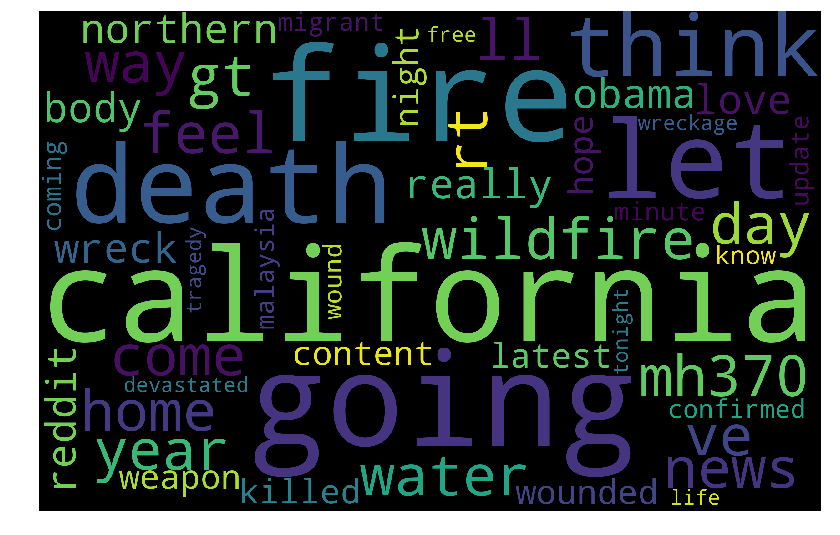

In [42]:
# Wordcloud of first topic
firstcloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          width=2500,
                          height=1600
                         ).generate(" ".join(first_topic_words))
plt.figure(figsize=(14, 10))
plt.imshow(firstcloud)
plt.axis('off')
plt.show()

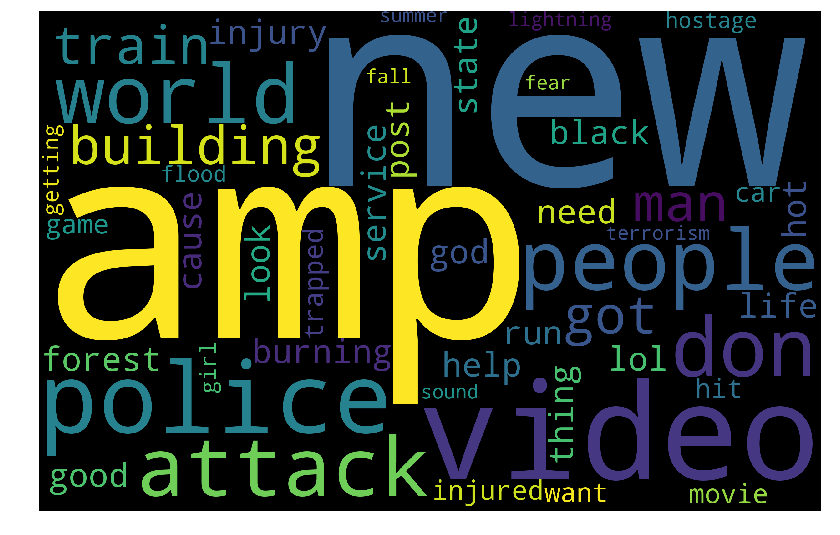

In [43]:
# Wordcloud of second topic
secondcloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          width=2500,
                          height=1600
                         ).generate(" ".join(second_topic_words))
plt.figure(figsize=(14, 10))
plt.imshow(secondcloud)
plt.axis('off')
plt.show()

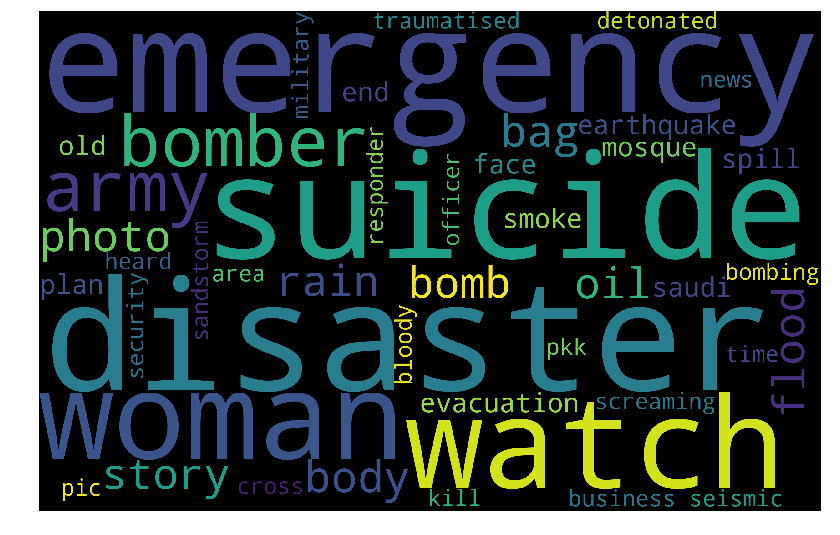

In [44]:
# Wordcloud of third topic
thirdcloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          width=2500,
                          height=1600
                         ).generate(" ".join(third_topic_words))
plt.figure(figsize=(14, 10))
plt.imshow(thirdcloud)
plt.axis('off')
plt.show()

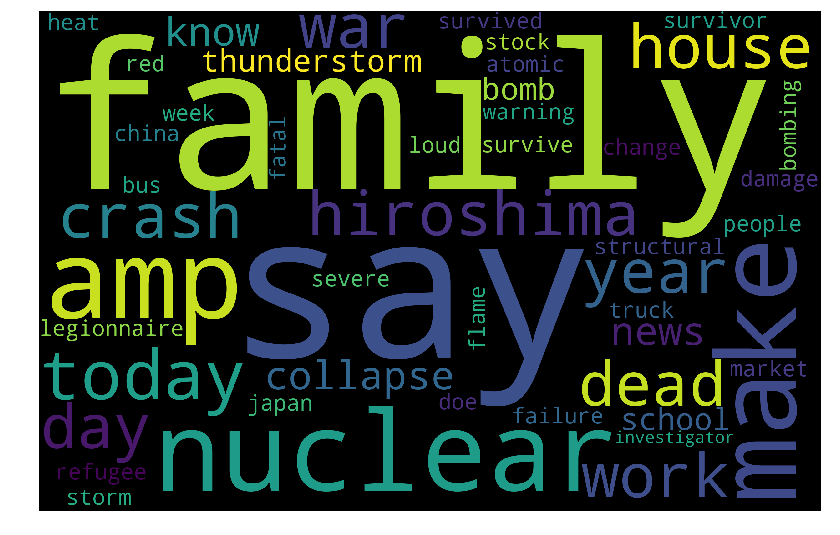

In [45]:
# Wordcloud of fourth topic
fourthcloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          width=2500,
                          height=1600
                         ).generate(" ".join(fourth_topic_words))
plt.figure(figsize=(14, 10))
plt.imshow(fourthcloud)
plt.axis('off')
plt.show()